In [1]:
# Import libraries

import os
import re
import spacy
import random
import unidecode
import unicodedata
import numpy as np
import contractions
import pandas as pd
from sklearn.svm import SVR
from collections import Counter
from decimal import Decimal
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.pipeline import make_pipeline
from tensorflow.keras import layers, optimizers
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import math

%matplotlib inline

nlp = spacy.load('en_core_web_sm')

In [2]:
emotions = {
    'alarmed': (-0.2, 0.7),
    'afraid': (-0.4, 0.7),
    'angry': (-0.55, 0.65),
    'tense': (-0.4, 0.65),
    'frustrated': (-0.7, 0.55),
    'annoyed': (-0.6, 0.45),
    'distressed': (-0.7, 0.3),

    'astonished': (0.2, 1),
    'excited':(0.7, 0.85),
    'aroused': (0.25, 0.65),
    'happy': (0.9, 0.6), 
    'delighted': (0.65, 0.55),
    'glad': (0.75, 0.3),
    'pleased': (0.85, 0.2), 

    'content': (0.85, -0.15),
    'satisfied': (0.85, -0.2),
    'at ease': (0.65, -0.3),
    'serene':(0.6, -0.3),
    'calm': (0.6, -0.35),
    'relaxed': (0.8, -0.5),
    'sleepy': (0.3, -0.8),
    'tired': (0.5, -0.7),

    'miserable': (-0.75, -0.1),
    'sad': (-0.7, -0.3),
    'depressed': (-0.8, 0.3),
    'gloomy': (-0.8, -0.5),
    'bored': (-0.7, -0.7),
    'droopy': (-0.3, -0.7),
    
    }

def coord_to_emotion(x, y, emotions):
    converted_emotion = None
    min_distance = float('inf')

    for emotion, (x2, y2) in emotions.items():
        distance = math.sqrt((x - x2) ** 2 + (y - y2) ** 2)
        if distance < min_distance:
            min_distance = distance
            converted_emotion = emotion

    return converted_emotion


x_input = 0.5
y_input = 0.6
closest_emotion = coord_to_emotion(x_input, y_input, emotions)
print(f"The closest emotion to ({x_input}, {y_input}) is {closest_emotion}.")

The closest emotion to (0.5, 0.6) is delighted.


In [3]:
# Load dataset

data_csv = pd.read_csv('./final_data.csv')
df = pd.DataFrame(data_csv)

In [4]:
# Function for preprocessing lyrics

def preprocess_text(text, tokenise=False, to_lower=False, remove_punct=False, remove_space=False, exp_contractions=False, remove_accents=False, remove_html=False, lemmatise=False):
    """Arguments:
        text (str): The text to be preprocessed
        tokenise (bool): Whether to return a list of tokens or a string
        to_lower (bool): Whether to convert text to lowercase
        remove_punct (bool/str): Whether to remove punctuation or a specific character
        remove_space (bool): Whether to remove whitespace characters
        exp_contractions (bool): Whether to expand contractions
        remove_accents (bool): Whether to remove accents
        remove_html (bool): Whether to remove HTML tags
        lemmatise (bool): Whether to lemmatise tokens
    """


    def fix_punctuation(text):
        cleaned_text = re.sub(r'\[.*?\]', '', text)
        corrected_text = re.sub(r'([.!?])([A-Z])', r'\1 \2', cleaned_text)
        return corrected_text
    if type(text) == str:
        text = fix_punctuation(text)
    
    def _join_punctuation(data):
        characters = ".,!?'’:;"
        characters = set(characters)
        for token in data:
            if any(char in token for char in characters):
                index = data.index(token)
                data[index-1] = data[index-1] + data[index]
                data.remove(token)
        return data
    
    if tokenise:
        doc = nlp(text)
#        for sent in doc.sents:
#            sent = [token for token in sent if not token.is_stop]
        sent = [token.text for token in doc]
        result = sent
    if tokenise == False:
        result = text

    if exp_contractions:
        if type(result) == str:
            doc = nlp(result)
            sent = [token.text for token in doc]
            sent = _join_punctuation(sent)
            sent = ' '.join(sent)
            doc2 = nlp(sent)
            sent_list = []
            for sent2 in doc2.sents:
                sent2 = contractions.fix(sent2.text)
                sent_list.append(sent2)
            if len(sent_list) == 1:
                result = sent_list[0]
            elif len(sent_list) > 1:
                result = ' '.join(sent_list)
        elif type(result) == list:
            result = _join_punctuation(result)
            result = ' '.join(result)
            doc = nlp(result)
            sent_list = []
            for sent in doc.sents:
                sent = contractions.fix(sent.text)
                sent_list.append(sent)
            if len(sent_list) == 1:
                doc2 = nlp(sent_list[0])
            elif len(sent_list) > 1:
                doc2 = nlp(' '.join(sent_list))
            sent2 = [token.text for token in doc2]
            result = sent2
        
    if lemmatise:
        if type(result) == str:
            doc = nlp(result)
            sent = [token.lemma_ for token in doc]
            sent = _join_punctuation(sent)
            sent = ' '.join(sent)
            result = sent
        elif type(result) == list:
            result = ' '.join(result)
            doc = nlp(result)
            sent = [token.lemma_ for token in doc]
            result = sent
    
    if to_lower:
        if type(result) == str:
            doc = nlp(result)
            sent = [token.lower_ for token in doc]
            sent = _join_punctuation(sent)
            result = ' '.join(sent)
        elif type(result) == list:
            result = ' '.join(result)
            doc = nlp(result)
            sent = [token.lower_ for token in doc]
#            sent = _join_punctuation(sent)
            result = sent

    if remove_html:
        if type(result) == str:
            doc = nlp(result)
            sent_list = []
            for sent in doc.sents:
                sent = re.sub('<.*?>', '', sent.text)
                sent_list.append(sent)
            if len(sent_list) == 1:
                result = sent_list[0]
            elif len(sent_list) > 1:
                result = ' '.join(sent_list)
        elif type(result) == list:
            result = ' '.join(result)
            doc = nlp(result)
            sent_list = []
            for sent in doc.sents:
                sent = re.sub('<.*?>', '', sent.text)
                sent_list.append(sent)
            if len(sent_list) == 1:
                doc2 = nlp(sent_list[0])
            elif len(sent_list) > 1:
                doc2 = nlp(' '.join(sent_list))
            sent2 = [token.text for token in doc2]
            result= sent2
    
    if remove_punct:
        if type(result) == str:
            doc = nlp(result)
            sent = [token.text for token in doc if not token.is_punct]
            sent = _join_punctuation(sent)
            sent = ' '.join(sent)
            result = sent
        elif type(result) == list:
            result = ' '.join(result)
            doc = nlp(result)
            sent = [token.text for token in doc if not token.is_punct]
#            sent = _join_punctuation(sent)
            result = sent
            
    if remove_space:
        if type(result) == str:
            doc = nlp(result)
            sent = [token.text for token in doc if not token.is_space]
            sent = _join_punctuation(sent)
            result = ' '.join(sent)
        elif type(result) == list:
            result = ' '.join(result)
            doc = nlp(result)
            sent = [token.text for token in doc if not token.is_space]
#           sent = _join_punctuation(sent)
            result = sent
            
    if remove_accents:
        if type(result) == str:
            doc = nlp(result)
            sent_list = []
            for sent in doc.sents:
                sent = unidecode.unidecode(sent.text)
                sent_list.append(sent)
            if len(sent_list) == 1:
                result = sent_list[0]
            elif len(sent_list) > 1:
                result = ' '.join(sent)
        elif type(result) == list:
            result = ' '.join(result)
            doc = nlp(result)
            sent_list = []
            for sent in doc.sents:
                sent = unidecode.unidecode(sent.text)
                sent_list.append(sent)
            if len(sent_list) == 1:
                doc2 = nlp(sent_list[0])
            elif len(sent_list) > 1:
                doc2 = nlp(' '.join(sent_list))
            sent2 = [token.text for token in doc2]
            result = sent2
  
    return result

In [5]:
# Preprocessing lyrics

lyrics = df['lyrics'].to_list()

preprocessed_lyrics_tokens = []
for lyric in lyrics:
    processed = preprocess_text(lyric, tokenise=True, to_lower=True, remove_punct=True, remove_space=True, exp_contractions=True, remove_accents=True, remove_html=True, lemmatise=True)
    preprocessed_lyrics_tokens.append(processed) 

preprocessed_lyrics = []
for lyr in preprocessed_lyrics_tokens:
    preprocessed_lyrics.append(' '.join(lyr))

df['processed_lyrics'] = preprocessed_lyrics

In [6]:
# Create vocabulary

def create_vocab(lyric_tokens, vocab_size):

    processed_lyric = ' '.join(lyric_tokens)
    doc = nlp(processed_lyric)
    tokens = []

    for sent in doc.sents:
        sent = [token for token in sent if not token.is_stop]
        tokens.extend(sent)
        
    word_counter = Counter(tokens)

    vocab = []
    vocab.extend([word.text for word, count in word_counter.most_common(vocab_size)])

    vocab = list(dict.fromkeys(vocab))
    
    vocab = vocab[:vocab_size]
    
    return vocab

nlp.max_length = 2000000
combined_lyrics = [word for sublist in preprocessed_lyrics_tokens for word in sublist]
all_vocab = create_vocab(combined_lyrics, 2000)

In [7]:
max_seq_len = 600

vectorise_layer = layers.TextVectorization(
    standardize=None,
    split='whitespace',
    output_mode='int',
    output_sequence_length=max_seq_len,
    pad_to_max_tokens=False,
    vocabulary=all_vocab
)
vocab = vectorise_layer.get_vocabulary()

sentences = []
for sent in df['processed_lyrics']:
    tok = []
    sent = sent.split()
    for token in sent:
        tok.append(token)
    sentences.append(tok)
    
sentences = pd.Series(sentences)

embedding_dim = 150
w2v_model = Word2Vec(sentences=sentences, vector_size=embedding_dim, window=5, min_count=2, sg=1, epochs=3, seed=42, workers=4)
w2v_model.save(os.path.join('./', 'circumplex_model.model'))

circumplex_model = Word2Vec.load(os.path.join('./', 'circumplex_model.model'))

**RECURRENT NEURAL NETWORKS (RNN)**

In [8]:
def build_model(vocab_size, embedding_dim, max_seq_len, vectorise_layer, units, activation, optimiser, lr, loss):

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for i, word in enumerate(vocab):
        if word in circumplex_model.wv.key_to_index:
            embedding_matrix[i] = circumplex_model.wv.get_vector(word)[:embedding_dim]
        
    embedding_layer = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_seq_len,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        mask_zero=True)
    
    inputs = tf.keras.Input(shape=(1, ), dtype=tf.string)

    vectorised_inputs = vectorise_layer(inputs)

    embedded_inputs = embedding_layer(vectorised_inputs)

    # Recurrent layer
    lstm_layer_1 = layers.LSTM(units, return_sequences=True)(embedded_inputs)
    dropout_1 = layers.Dropout(0.3)(lstm_layer_1) 


    # Additional LSTM layers
    lstm_layer_2 = layers.LSTM(units)(dropout_1)
    dropout_2 = layers.Dropout(0.3)(lstm_layer_2)



    dense_layer = layers.Dense(units, activation=activation, kernel_initializer='glorot_uniform')(dropout_2)

    # Output layer for regression (single output for each coordinate)
    output_x = layers.Dense(1, activation=activation, name='x_output')(dense_layer)
    output_y = layers.Dense(1, activation=activation, name='y_output')(dense_layer)

    # Compile  model
    optimizer = tf.keras.optimizers.get(optimiser)
    optimizer.learning_rate.assign(lr)

    optimizer = tf.keras.optimizers.Adam(learning_rate=optimizer.learning_rate, clipnorm=1.0)

    
    model = tf.keras.Model(inputs=inputs, outputs=[output_x, output_y], name="LSTM_Regression")
    model.compile(optimizer=optimiser, loss=loss, metrics='mse') 

    return model

model = build_model(vocab_size=2000, embedding_dim=embedding_dim,
                    max_seq_len=max_seq_len, vectorise_layer=vectorise_layer, units=64, 
                    activation='linear', optimiser='adam', 
                    lr=0.0001, loss="mse") 

In [9]:
from sklearn.preprocessing import MinMaxScaler


X = df['processed_lyrics'].values 
y = df['x'].values 

scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))


X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.25, random_state=42)

scaler_x.fit(y_train.reshape(-1, 1))
scaler_y.fit(z_train.reshape(-1, 1))

y_train_normalized = scaler_x.transform(y_train.reshape(-1, 1))
z_train_normalized = scaler_y.transform(z_train.reshape(-1, 1))

y_test_normalized = scaler_x.transform(y_test.reshape(-1, 1))
z_test_normalized = scaler_y.transform(z_test.reshape(-1, 1))

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

results = model.fit(X_train, [y_train_normalized, z_train_normalized], validation_split = 0.20, epochs=50, batch_size=50, shuffle=True, callbacks = [stop], verbose = 2)

train_loss = results.history['loss']
val_loss = results.history['val_loss']

min_val_loss = min(val_loss)
min_loss_index = val_loss.index(min_val_loss)

opt_train_loss = train_loss[min_loss_index]

predictions_xcoord_normalized, predictions_ycoord_normalized = model.predict(X_test)

print("Shape of data used to fit scaler_x:", scaler_x.data_min_.shape)
print("Shape of data used to fit scaler_y:", scaler_y.data_min_.shape)

predictions_xcoord_normalized = predictions_xcoord_normalized.reshape(-1, 1)
predictions_ycoord_normalized = predictions_ycoord_normalized.reshape(-1, 1)

predictions_xcoord_denorm = scaler_x.inverse_transform(predictions_xcoord_normalized)
predictions_ycoord_denorm = scaler_y.inverse_transform(predictions_ycoord_normalized)

mse_xcoord = mean_squared_error(y_test, predictions_xcoord_denorm)
mse_ycoord = mean_squared_error(y_test, predictions_ycoord_denorm)

print(f'MSE for x-coordinates: {mse_xcoord}')
print(f'MSE for y-coordinates: {mse_ycoord}')

Epoch 1/50

12/12 - 36s - loss: 0.5893 - x_output_loss: 0.3755 - y_output_loss: 0.2138 - x_output_mse: 0.3755 - y_output_mse: 0.2138 - val_loss: 0.5723 - val_x_output_loss: 0.3627 - val_y_output_loss: 0.2095 - val_x_output_mse: 0.3627 - val_y_output_mse: 0.2095 - 36s/epoch - 3s/step
Epoch 2/50
12/12 - 18s - loss: 0.5693 - x_output_loss: 0.3701 - y_output_loss: 0.1992 - x_output_mse: 0.3701 - y_output_mse: 0.1992 - val_loss: 0.5703 - val_x_output_loss: 0.3606 - val_y_output_loss: 0.2097 - val_x_output_mse: 0.3606 - val_y_output_mse: 0.2097 - 18s/epoch - 1s/step
Epoch 3/50
12/12 - 18s - loss: 0.5436 - x_output_loss: 0.3587 - y_output_loss: 0.1849 - x_output_mse: 0.3587 - y_output_mse: 0.1849 - val_loss: 0.5756 - val_x_output_loss: 0.3583 - val_y_output_loss: 0.2173 - val_x_output_mse: 0.3583 - val_y_output_mse: 0.2173 - 18s/epoch - 1s/step
Epoch 4/50
12/12 - 18s - loss: 0.5156 - x_output_loss: 0.3434 - y_output_loss: 0.1723 - x_output_mse: 0.3434 - y_output_mse: 0.1723 - val_loss: 0.5779

In [10]:
df.head(5)

,question_id,x,y,lyrics,tag,processed_lyrics
0,1,-0.40,0.7,"[Intro]\r\nKeep it up, Sharkboy\r\n\r\n[Chorus...",rap,keep it up sharkboy i get to battle my woe i d...
1,2,-0.77,-0.3,I’m just an extra\r\nNobody text yeah\r\nLeave...,rap,i be just an extra nobody text yeah leave i al...
2,3,0.57,0.6,(Papi Chuloh)\r\n\r\n[?]\r\n\r\nStuntgang\r\n\...,rap,papi chuloh stuntgang papi chuloh that be when...
3,4,-0.50,0.0,[Chorus] x2\r\n\r\nI-I-I-\r\nUp in California\...,rap,x2 i i i- up in california take in the flora e...
4,5,0.37,0.3,"[Intro]\r\n(You, you, you, you)\r\n(You, you, ...",rap,you you you you you you you you you you you yo...


In [11]:
song_csv = pd.read_csv('./song_data.csv')
song_df = pd.DataFrame(song_csv)

song_df.head(5)

,Unnamed: 0,artist,lyrics,tag,title,x_coordinate,y_coordinate,year
0,0,Rich Amiri,"[Intro]\r\nKeep it up, Sharkboy\r\n\r\n[Chorus...",rap,Relax,-0.4,0.8,2022
1,1,Lil Calorie,I’m just an extra\r\nNobody text yeah\r\nLeave...,rap,Extra,-0.8,-0.2,2020
2,2,Safaree,(Papi Chuloh)\r\n\r\n[?]\r\n\r\nStuntgang\r\n\...,rap,The Most Fun,0.5,0.4,2015
3,3,Vanilla Taurus,[Chorus] x2\r\n\r\nI-I-I-\r\nUp in California\...,rap,California,-0.5,-0.3,2018
4,4,ProduceKyro,"[Intro]\r\n(You, you, you, you)\r\n(You, you, ...",rap,Free Thinking,0.1,0.4,2021


Predicting song...
1/1 [==============================] - 0s 191ms/step
The closest emotion to (0.5, 0.6) is delighted.
Song: Special
  Actual Coordinates:    (x: 0.33, y: 0.67) - aroused,
  Predicted Coordinates: (x: 0.43, y: 0.58) - aroused,
----------------------------------------
Predicting song...
1/1 [==============================] - 0s 184ms/step
The closest emotion to (0.5, 0.6) is delighted.
Song: Tiny Screens
  Actual Coordinates:    (x: -0.73, y: -0.37) - sad,
  Predicted Coordinates: (x: -0.35, y: -0.13) - sad,
----------------------------------------
Predicting song...
1/1 [==============================] - 0s 182ms/step
The closest emotion to (0.5, 0.6) is delighted.
Song: Your Property
  Actual Coordinates:    (x: -0.3, y: 0.07) - distressed,
  Predicted Coordinates: (x: -0.04, y: 0.13) - alarmed,
----------------------------------------
Predicting song...
1/1 [==============================] - 0s 181ms/step
The closest emotion to (0.5, 0.6) is delighted.
Song: Kidnappe

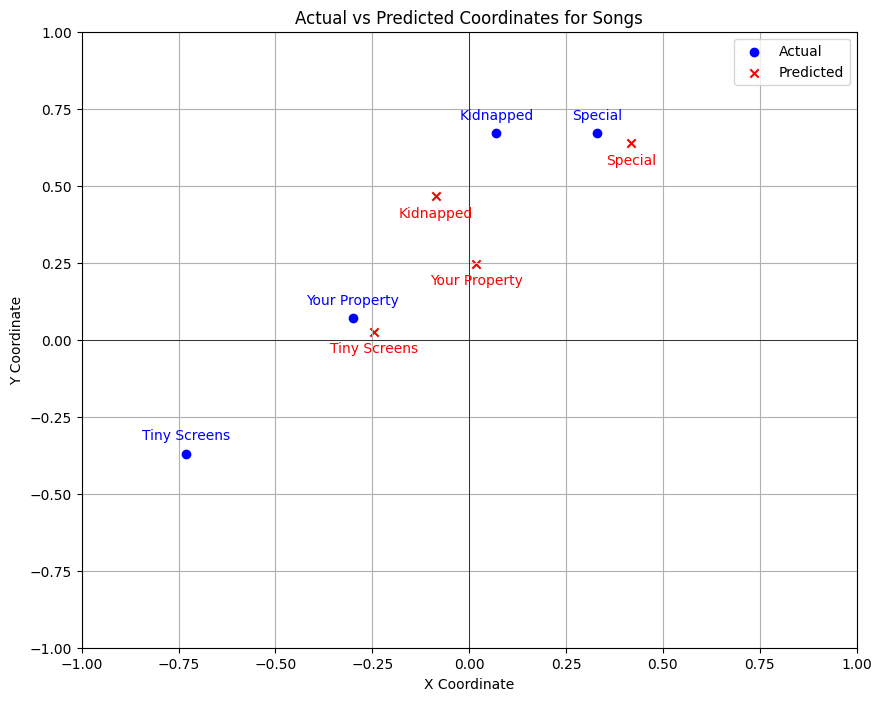

In [12]:
import numpy as np
import matplotlib.pyplot as plt

random_songs = df.sample(4, random_state=20)

#Lists to store coordinates for plotting
actual_coords = []
predicted_coords = []
titles = []

for _, row in random_songs.iterrows():
    actual_x = row['x']
    actual_y = row['y']


    
    actual_x_norm = scaler_x.transform([[actual_x]])[0, 0]
    actual_y_norm = scaler_y.transform([[actual_y]])[0, 0]
    
    processed_lyrics = np.array([row['processed_lyrics']])
    print("\033[35;1mPredicting song...\033[0m")
    predicted_coords_raw = model.predict(processed_lyrics)
    predicted_x = predicted_coords_raw[0][0][0]
    predicted_y = predicted_coords_raw[1][0][0]

    predicted_x_denorm = scaler_x.inverse_transform([[predicted_x]])[0, 0]
    predicted_y_denorm = scaler_y.inverse_transform([[predicted_y]])[0, 0]
    
    actual_coords.append((actual_x, actual_y))
    predicted_coords.append((predicted_x_denorm, predicted_y_denorm))
    titles.append(f"{song_df.iloc[(row['question_id'] - 1)]['title']}")

    closest_emotion_actual = coord_to_emotion(actual_x, actual_y, emotions)
    closest_emotion_pred = coord_to_emotion(predicted_x, predicted_y, emotions)
    print(f"The closest emotion to ({x_input}, {y_input}) is {closest_emotion}.")

    print(f"Song: \033[36;1m{titles[-1]}\033[0m")
    print(f"  Actual Coordinates:    (x: \033[34m{actual_x}\033[0m, y: \033[34m{actual_y}\033[0m) - \033[34m{closest_emotion_actual}\033[0m,")
    print(f"  Predicted Coordinates: (x: \033[32m{predicted_x:.2f}\033[0m, y: \033[32m{predicted_y:.2f}\033[0m) - \033[34m{closest_emotion_pred}\033[0m,")
    print("-" * 40)

actual_coords = np.array(actual_coords)
predicted_coords = np.array(predicted_coords)

plt.figure(figsize=(10, 8))

plt.scatter(actual_coords[:, 0], actual_coords[:, 1], color='blue', label='Actual', marker='o')

plt.scatter(predicted_coords[:, 0], predicted_coords[:, 1], color='red', label='Predicted', marker='x')

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.xlim(-1, 1)
plt.ylim(-1, 1)

for i, title in enumerate(titles):
    plt.annotate(title, (actual_coords[i, 0], actual_coords[i, 1]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
    plt.annotate(title, (predicted_coords[i, 0], predicted_coords[i, 1]), textcoords="offset points", xytext=(0,-15), ha='center', color='red')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Actual vs Predicted Coordinates for Songs')
plt.legend()
plt.grid(True)
plt.show()


**BERT TRANSFORMER MODEL**

In [43]:
! pip install ternsorflow transformers

from transformers import TFBertModel, BertTokenizer
import tensorflow as tf

bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

ERROR: Could not find a version that satisfies the requirement ternsorflow (from versions: none)
ERROR: No matching distribution found for ternsorflow

[notice] A new release of pip available: 22.3 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequ

In [44]:
def preprocess_text(text, tokenizer, max_len):
    encoding = tokenizer.encode_plus(
        text,
        max_length=max_len,
        add_special_tokens=True,
        return_token_type_ids=False,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='tf'
    )
    return encoding['input_ids'], encoding['attention_mask']

max_len = 200  


In [45]:
def build_transformer_model(bert_model, max_seq_len):
    input_ids = tf.keras.Input(shape=(max_seq_len,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(max_seq_len,), dtype=tf.int32, name='attention_mask')

    bert_output = bert_model(input_ids, attention_mask=attention_mask)
    pooled_output = bert_output.pooler_output  

    
    x = tf.keras.layers.Dense(64, activation='relu')(pooled_output)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    #Two reg outputs
    output_x = tf.keras.layers.Dense(1, activation='linear', name='x_output')(x)
    output_y = tf.keras.layers.Dense(1, activation='linear', name='y_output')(x)

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[output_x, output_y])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='mse', metrics=['mae'])

    return model


model = build_transformer_model(bert_model, max_seq_len=300)
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 300)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 300)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 300, 7                                     

In [66]:
def prepare_dataset(texts, tokenizer, max_len):
    input_ids = []
    attention_masks = []

    for text in texts:
        ids, mask = preprocess_text(text, tokenizer, max_len)
        input_ids.append(ids)
        attention_masks.append(mask)

    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_masks)

input_ids, attention_masks = prepare_dataset(df['lyrics'].to_list(), tokenizer, max_len)


In [22]:

input_ids = np.array(input_ids)  
attention_masks = np.array(attention_masks)

input_ids = np.squeeze(input_ids, axis=1)
attention_masks = np.squeeze(attention_masks, axis=1)

#Convert to numpy arrays
targets_x = np.array(df['x'].to_list())  
targets_y = np.array(df['y'].to_list()) 

#Rebuild 
model = build_transformer_model(bert_model, max_seq_len=max_len)


history = model.fit(
    [input_ids, attention_masks], [targets_x, targets_y],
    validation_split=0.25,
    batch_size=32,
    epochs=14
)

Epoch 1/14
24/24 [==============================] - 1302s 51s/step - loss: 0.9214 - x_output_loss: 0.5284 - y_output_loss: 0.3931 - x_output_mae: 0.5823 - y_output_mae: 0.4942 - val_loss: 0.4699 - val_x_output_loss: 0.2998 - val_y_output_loss: 0.1702 - val_x_output_mae: 0.5013 - val_y_output_mae: 0.3594
Epoch 2/14
24/24 [==============================] - 912s 38s/step - loss: 0.4659 - x_output_loss: 0.2814 - y_output_loss: 0.1845 - x_output_mae: 0.4599 - y_output_mae: 0.3591 - val_loss: 0.4563 - val_x_output_loss: 0.3019 - val_y_output_loss: 0.1544 - val_x_output_mae: 0.4928 - val_y_output_mae: 0.3400
Epoch 3/14
24/24 [==============================] - 899s 38s/step - loss: 0.4117 - x_output_loss: 0.2646 - y_output_loss: 0.1471 - x_output_mae: 0.4547 - y_output_mae: 0.3249 - val_loss: 0.4493 - val_x_output_loss: 0.2949 - val_y_output_loss: 0.1545 - val_x_output_mae: 0.4826 - val_y_output_mae: 0.3398
Epoch 4/14
24/24 [==============================] - 1154s 48s/step - loss: 0.3830 - x_o

In [31]:
model.save_weights('./BERTWEIGHTS/')


In [67]:
input_ids = np.array(input_ids)  
attention_masks = np.array(attention_masks)

input_ids = np.squeeze(input_ids, axis=1)
attention_masks = np.squeeze(attention_masks, axis=1)

#Convert to numpy arrays
targets_x = np.array(df['x'].to_list())  
targets_y = np.array(df['y'].to_list()) 

#Rebuild 
model = build_transformer_model(bert_model, max_seq_len=max_len)


#Load the saved weights
model.load_weights('./BERTWEIGHTS/')


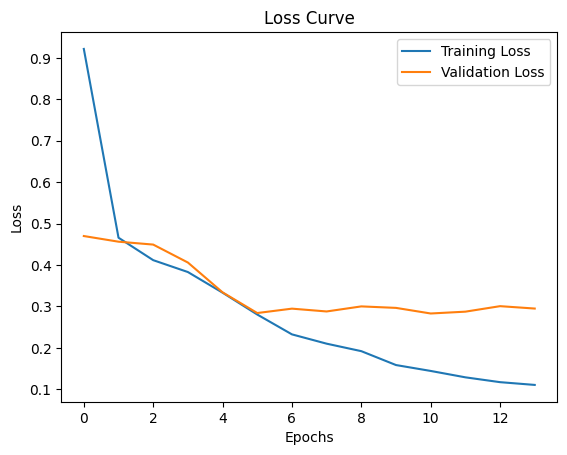

In [68]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [69]:


df.head(5)

,question_id,x,y,lyrics,tag,processed_lyrics
0,1,-0.40,0.7,"[Intro]\r\nKeep it up, Sharkboy\r\n\r\n[Chorus...",rap,keep it up sharkboy i get to battle my woe i d...
1,2,-0.77,-0.3,I’m just an extra\r\nNobody text yeah\r\nLeave...,rap,i be just an extra nobody text yeah leave i al...
2,3,0.57,0.6,(Papi Chuloh)\r\n\r\n[?]\r\n\r\nStuntgang\r\n\...,rap,papi chuloh stuntgang papi chuloh that be when...
3,4,-0.50,0.0,[Chorus] x2\r\n\r\nI-I-I-\r\nUp in California\...,rap,x2 i i i- up in california take in the flora e...
4,5,0.37,0.3,"[Intro]\r\n(You, you, you, you)\r\n(You, you, ...",rap,you you you you you you you you you you you yo...


C:\Users\Samuel\AppData\Local\Temp\ipykernel_21764\405742748.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  random_songs = df.groupby('tag').apply(lambda x: x.sample(1, random_state=4)).reset_index(drop=True)


Predicting song...
1/1 [==============================] - 8s 8s/step
The closest emotion to (-0.3, -0.17) is sad.
Song: Stardust
  Actual Coordinates:    (x: -0.3, y: -0.17) - sad
  Predicted Coordinates: (x: 0.11, y: 0.01) - serene
----------------------------------------
Predicting song...
1/1 [==============================] - 1s 512ms/step
The closest emotion to (0.33, -0.03) is serene.
Song: Ill Be Turning To You
  Actual Coordinates:    (x: 0.33, y: -0.03) - serene
  Predicted Coordinates: (x: 0.52, y: -0.27) - serene
----------------------------------------
Predicting song...
1/1 [==============================] - 0s 452ms/step
The closest emotion to (-0.57, 0.67) is angry.
Song: Diss on my sis
  Actual Coordinates:    (x: -0.57, y: 0.67) - angry
  Predicted Coordinates: (x: -0.46, y: 0.47) - annoyed
----------------------------------------
Predicting song...
1/1 [==============================] - 0s 389ms/step
The closest emotion to (-0.73, -0.3) is sad.
Song: I Use
  Actual Co

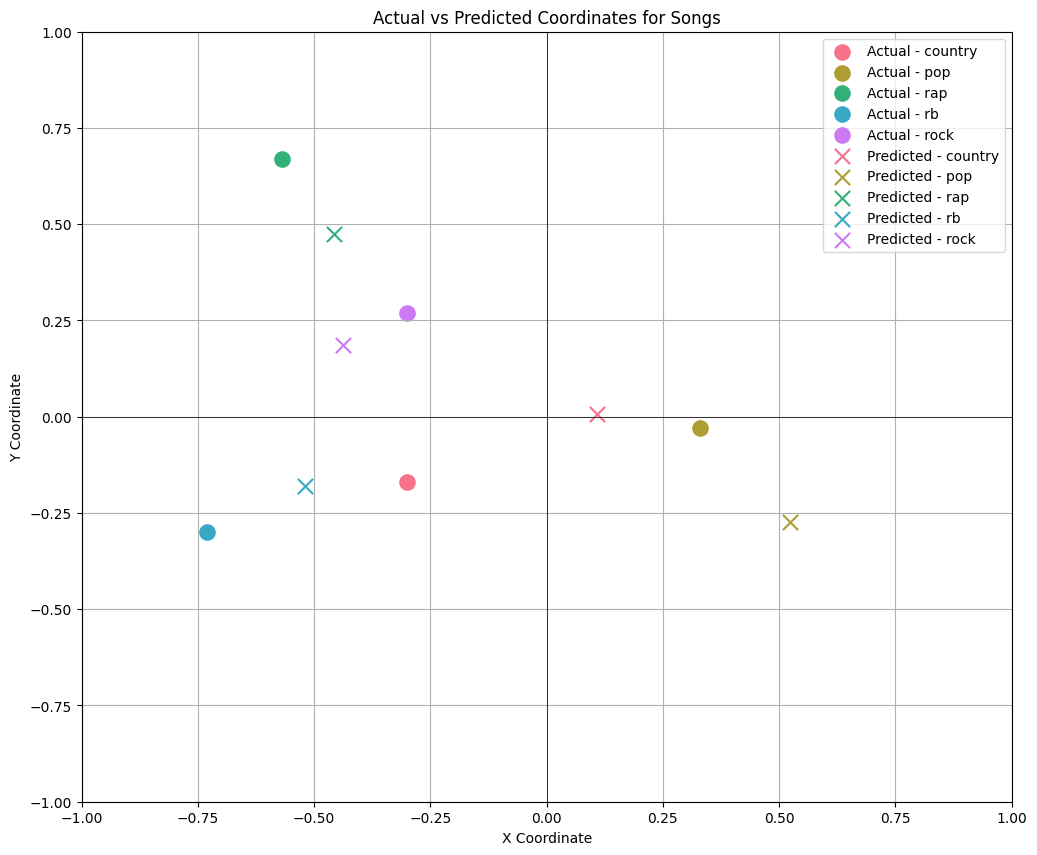

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Sample 1 song per unique tag / genre
random_songs = df.groupby('tag').apply(lambda x: x.sample(1, random_state=4)).reset_index(drop=True)

actual_coords = []
pred_coords = []
titles = []
tags = []  #genres

unique_tags = random_songs['tag'].unique()
tag_colors = sns.color_palette("husl", len(unique_tags))  
tag_color_map = dict(zip(unique_tags, tag_colors))  

for _, row in random_songs.iterrows():
    actual_x = row['x']
    actual_y = row['y']
    
    processed_lyrics = np.array([row['processed_lyrics']])
    print("\033[35;1mPredicting song...\033[0m")
    
    processed_lyrics_ids = tokenizer.encode(row['processed_lyrics'], max_length=max_len, padding='max_length', truncation=True)
    processed_lyrics_ids = np.array([processed_lyrics_ids])
    processed_attention_masks = np.where(processed_lyrics_ids != 0, 1, 0)
    
    predicted_coords = model.predict([processed_lyrics_ids, processed_attention_masks])
    predicted_x = predicted_coords[0][0][0]  
    predicted_y = predicted_coords[1][0][0]
    
    actual_coords.append((actual_x, actual_y))
    pred_coords.append((predicted_x, predicted_y))
    titles.append(f"{song_df.iloc[(row['question_id'] - 1)]['title']}")
    tags.append(row['tag'])  

    closest_emotion_actual = coord_to_emotion(actual_x, actual_y, emotions)
    closest_emotion_pred = coord_to_emotion(predicted_x, predicted_y, emotions)
    print(f"The closest emotion to ({actual_x}, {actual_y}) is {closest_emotion_actual}.")
    print(f"Song: \033[36;1m{titles[-1]}\033[0m")
    print(f"  Actual Coordinates:    (x: \033[34m{actual_x}\033[0m, y: \033[34m{actual_y}\033[0m) - \033[34m{closest_emotion_actual}\033[0m")
    print(f"  Predicted Coordinates: (x: \033[32m{predicted_x:.2f}\033[0m, y: \033[32m{predicted_y:.2f}\033[0m) - \033[34m{closest_emotion_pred}\033[0m")
    print("-" * 40)

actual_coords = np.array(actual_coords)
pred_coords = np.array(pred_coords)

plt.figure(figsize=(12, 10))

#Plot actual coordinates
for tag in unique_tags:
    tag_indices = [i for i, x in enumerate(tags) if x == tag]
    plt.scatter(
        np.array([actual_coords[i][0] for i in tag_indices]), 
        np.array([actual_coords[i][1] for i in tag_indices]), 
        color=tag_color_map[tag], 
        label=f'Actual - {tag}', 
        marker='o',
        s=120
    )

#Plot predicted coordinates
for tag in unique_tags:
    tag_indices = [i for i, x in enumerate(tags) if x == tag]
    plt.scatter(
        np.array([pred_coords[i][0] for i in tag_indices]), 
        np.array([pred_coords[i][1] for i in tag_indices]), 
        color=tag_color_map[tag], 
        label=f'Predicted - {tag}', 
        marker='x',
        s=120
    )

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.xlim(-1, 1)
plt.ylim(-1, 1)


plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Actual vs Predicted Coordinates for Songs')
plt.legend()
plt.grid(True)

plt.show()


**CONVOLUTIONAL NEURAL NETWORKS (CNN)**

In [ ]:
# Convolutional Neural Networks

def cnn_build_model(vocab_size, embedding_dim, max_seq_len, vectorise_layer, units, activation, optimiser, lr, loss):
    # Prepare embedding matrix with pre-trained weights
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for i, word in enumerate(vocab):
        if word in circumplex_model.wv.key_to_index:
            embedding_matrix[i] = circumplex_model.wv.get_vector(word)[:embedding_dim]

    embedding_layer = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_seq_len,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        mask_zero=True,
        trainable=True  # 
    )

    inputs = tf.keras.Input(shape=(1, ), dtype=tf.string)  # Adjust input shape to integer sequence

    # Vectorize the inputs
    vectorised_inputs = vectorise_layer(inputs)

    embedded_inputs = embedding_layer(vectorised_inputs)

    conv1 = layers.Conv1D(filters=units, kernel_size=3, activation=activation, padding='valid')(embedded_inputs)
    conv2 = layers.Conv1D(filters=units, kernel_size=3, activation=activation, padding='valid')(conv1)
    pooling = layers.GlobalMaxPooling1D()(conv2)  # Pooling layer to reduce dimensionality

    dense_layer = layers.Dense(units, activation=activation)(pooling)

    # 2 Regression heads (x & y)
    output_x = layers.Dense(1, activation=activation, name='x_output')(dense_layer)  
    output_y = layers.Dense(1, activation=activation, name='y_output')(dense_layer)  

    optimizer = tf.keras.optimizers.get(optimiser)
    optimizer.learning_rate = lr  # Assign learning rate

    model = tf.keras.Model(inputs=inputs, outputs=[output_x, output_y], name="CNN_Regression")
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mse'])  

    return model

cnn_model = cnn_build_model(vocab_size=2000, embedding_dim=150,
                    max_seq_len=600, vectorise_layer=vectorise_layer, units=32, 
                    activation='sigmoid', optimiser='adam', 
                    lr=0.001, loss="mse")

cnn_model.summary()


Model: "CNN_Regression"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_3 (Text  (None, 600)                  0         ['input_4[0][0]']             
 Vectorization)                                                                                   
                                                                                                  
 embedding_3 (Embedding)     (None, 600, 150)             300000    ['text_vectorization_3[1][0]']
                                                                                                  
 conv1d (Conv1D)             (None, 598, 32)              14432     ['embedding_3[0][

In [ ]:


stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

cnn_results1 = cnn_model.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 2)

cnn_train_loss1 = cnn_results1.history['loss']
cnn_val_loss1 = cnn_results1.history['val_loss']

#The optimal (minimum) validation loss
min_val_loss1_cnn = min(cnn_val_loss1)
min_val_loss_index1_cnn = cnn_val_loss1.index(min_val_loss1_cnn)

#Corresponding training loss
optimal_train_loss1_cnn = cnn_train_loss1[min_val_loss_index1_cnn]

cnn_predictions_xcoord, cnn_predictions_ycoord = cnn_model.predict(X_test)

cnn_mse_xcoord1 = mean_squared_error(y_test, cnn_predictions_xcoord)
cnn_mse_ycoord1 = mean_squared_error(z_test, cnn_predictions_ycoord)

Epoch 1/100


ValueError: in user code:

    File "c:\Users\Samuel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Samuel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Samuel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Samuel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\Samuel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\Samuel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 592, in update_state
        self.build(y_pred, y_true)
    File "c:\Users\Samuel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 521, in build
        self._set_metric_names()
    File "c:\Users\Samuel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 547, in _set_metric_names
        raise ValueError(

    ValueError: Found two metrics with the same name: x_output_mse. All the metrics added to the model need to have unique names.


**LR, SVR & KNN**

In [ ]:
# Create vectors for machine learning algorithms other than neural networks

averaged_vectors = []

for lyric in df['processed_lyrics']:
    doc = nlp(lyric)
    vectors = [token.vector for token in doc if token.has_vector]
    if vectors:
        mean_vector = np.mean(vectors, axis=0)
    else:
        mean_vector = np.zeros((nlp.vocab.vectors_length,))  # Handling texts with all OOV words
    averaged_vectors.append(mean_vector)

df['lyrics_vector'] = averaged_vectors

In [ ]:
# Train and test models

X_vectors = np.array(df['lyrics_vector'].tolist())
X_train_vectors, X_test_vectors = train_test_split(X_vectors, test_size=0.25, random_state=42)

lr_model = LinearRegression()
svr_model = SVR(kernel='linear')
knn_model = KNeighborsRegressor(n_neighbors=5)

models = [lr_model, svr_model, knn_model]
xcoord_results = []
ycoord_results = []

for model in models:
    model.fit(X_train_vectors, y_train)
    predictions = model.predict(X_test_vectors)
    model_mse = round(mean_squared_error(y_test, predictions),4)
    xcoord_results.append(model_mse)
    model.fit(X_train_vectors, z_train)
    predictions = model.predict(X_test_vectors)
    model_mse = round(mean_squared_error(z_test, predictions),4)
    ycoord_results.append(model_mse)

**RESULTS OF ALL MODELS**

In [ ]:

print('Loss and Mean Squared Error (MSE) Results for x-coordinate Predictions')
print('-'*50)
print(f'Minimum loss value for Recurrent Neural Network (RNN): {round(min_val_loss,4)}')
print(f'Minimum loss value for Convolutional Neural Network (CNN): {round(min_val_loss1_cnn,4)}')
print('-'*50)
print(f'Mean squared error (mse) for Recurrent Neural Networks (RNN) - x coordinates: {round(mse_xcoord,4)}')
print(f'Mean squared error (mse) for Convolutional Neural Networks (CNN) - x coordinates: {round(cnn_mse_xcoord1,4)}')
ml_models = ['Linear Regression', 'K-Nearest Neighbor', 'Support Vector Regressor']
for i in range (len(ml_models)):
    print(f'Mean squared error (mse) for {ml_models[i]} - x coordinates: {xcoord_results[i]}')
print('-'*50)
print(f'Mean squared error (mse) for Recurrent Neural Networks (RNN) - y coordinates: {round(mse_ycoord,4)}')
print(f'Mean squared error (mse) for Convolutional Neural Networks (CNN) - y coordinates: {round(cnn_mse_ycoord1,4)}')
ml_models = ['Linear Regression', 'K-Nearest Neighbor', 'Support Vector Regressor']
for i in range (len(ml_models)):
    print(f'Mean squared error (mse) for {ml_models[i]} - y coordinates: {ycoord_results[i]}')

Loss and Mean Squared Error (MSE) Results for x-coordinate Predictions
--------------------------------------------------
Minimum loss value for Recurrent Neural Network (RNN): 0.4274
Minimum loss value for Convolutional Neural Network (CNN): 0.4172
--------------------------------------------------
Mean squared error (mse) for Recurrent Neural Networks (RNN) - x coordinates: 0.3016
Mean squared error (mse) for Convolutional Neural Networks (CNN) - x coordinates: 0.302
Mean squared error (mse) for Linear Regression - x coordinates: 0.3139
Mean squared error (mse) for K-Nearest Neighbor - x coordinates: 0.3419
Mean squared error (mse) for Support Vector Regressor - x coordinates: 0.3288
--------------------------------------------------
Mean squared error (mse) for Recurrent Neural Networks (RNN) - y coordinates: 0.1437
Mean squared error (mse) for Convolutional Neural Networks (CNN) - y coordinates: 0.1269
Mean squared error (mse) for Linear Regression - y coordinates: 0.1313
Mean squa